# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
tic = time.time()

In [3]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.convenience import (
    create_route, stochastic_search, gradient_descent, Logs, LogsRoute
)
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice
import xarray as xr
import shapely

## Parameters

In [5]:
population_size = 512

# reproducibility
random_seed = 345

# data sources
current_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/gxfs_work/geomar/smomw122/2024_ship_routing/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# initial route
lon_waypoints = [-80.5, -12.0]
lat_waypoints = [30.0, 45.0]
time_start = "2021-08-01T12:00"
# time_end = "2021-08-21T12:00"
time_end = None
speed_knots = 7.0  # either one time and speed or both times needed
time_resolution_hours = 12.0

# stochastic search parameters
# stoch_number_of_iterations = 1
# stoch_acceptance_rate_target = 0.01

# gradient descent parameters
grad_num_iterations = 1
grad_learning_rate_percent_time = 0.5
grad_time_increment = 1_200
grad_learning_rate_percent_along = 0.5
grad_dist_shift_along = 15_000
grad_learning_rate_percent_across = 0.5
grad_dist_shift_across = 15_000

# experiment id
experiment_id = 2

In [6]:
np.random.seed(random_seed)

## Define a route

In [7]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=time_start,
    time_end=time_end,
    speed_knots=speed_knots,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-01T12:00:00')), WayPoint(lon=-79.21575362031135, lat=30.805756992465852, time=np.datetime64('2021-08-01T23:45:04.149')), WayPoint(lon=-77.91007287073641, lat=31.598477743602082, time=np.datetime64('2021-08-02T11:30:08.299')), WayPoint(lon=-76.58228001811983, lat=32.37753160291453, time=np.datetime64('2021-08-02T23:15:12.449')), WayPoint(lon=-75.2317181733898, lat=33.14226774921861, time=np.datetime64('2021-08-03T11:00:16.599')), WayPoint(lon=-73.85775640205404, lat=33.892015224837415, time=np.datetime64('2021-08-03T22:45:20.749')), WayPoint(lon=-72.45979537063289, lat=34.62608313731345, time=np.datetime64('2021-08-04T10:30:24.899')), WayPoint(lon=-71.03727353778287, lat=35.343761052265044, time=np.datetime64('2021-08-04T22:15:29.049')), WayPoint(lon=-69.58967388924779, lat=36.04431960224458, time=np.datetime64('2021-08-05T10:00:33.199')), WayPoint(lon=-68.11653120387712, lat=36.727011337

In [8]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 3.6011115271839906


## Load and plot currents, winds, waves

In [9]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [10]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

<xarray.HashableDataset> Size: 41GB
Dimensions:  (time: 8760, lat: 440, lon: 880)
Coordinates:
  * lat      (lat) float32 2kB 10.06 10.19 10.31 10.44 ... 64.69 64.81 64.94
  * lon      (lon) float32 4kB -99.94 -99.81 -99.69 -99.56 ... 9.688 9.812 9.938
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    uw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    vw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    speed    (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>

In [11]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves

<xarray.HashableDataset> Size: 4GB
Dimensions:  (time: 2920, lat: 276, lon: 551)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... 9.4 9.6 9.8 10.0
  * time     (time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    wh       (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
    VMDR     (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>

## Subset for the route

In [12]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 946 ms, sys: 595 ms, total: 1.54 s
Wall time: 644 ms
CPU times: user 8.97 s, sys: 10.2 s, total: 19.2 s
Wall time: 2.14 s
CPU times: user 150 ms, sys: 86.4 ms, total: 237 ms
Wall time: 98.4 ms


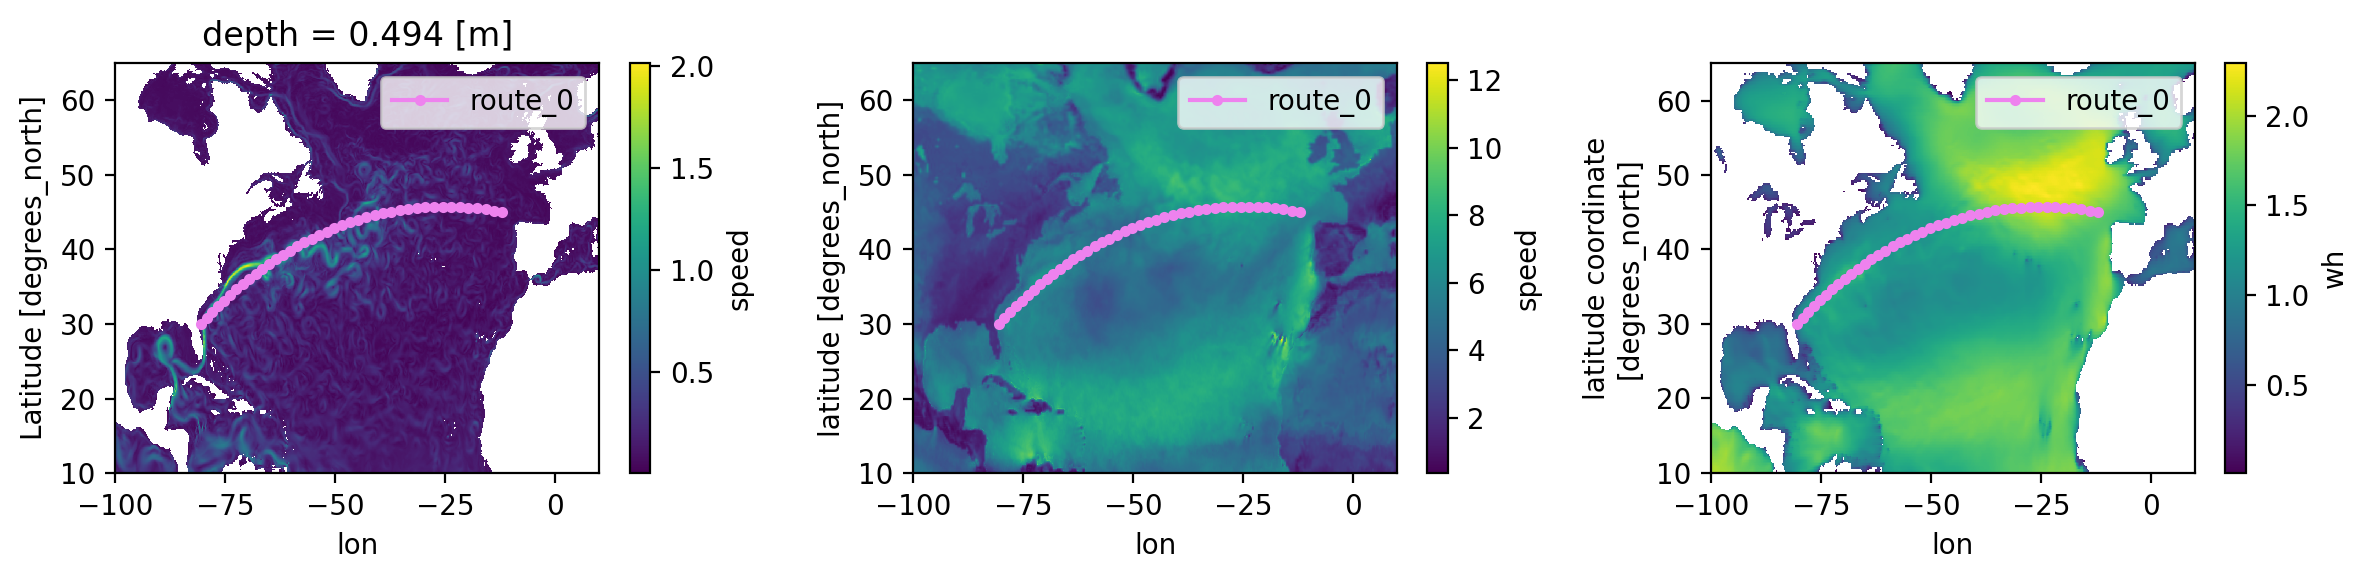

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Concurrency

In [14]:
from dask import delayed

In [15]:
@delayed
def stochastic_search_delayed(logs_routes, **kwargs):
    route = logs_routes.route
    mod_width = np.random.uniform(0, 1) * route.length_meters
    _route, _logs_routes = stochastic_search(
        route=route,
        mod_width=mod_width,
        max_move_meters=0.75 * mod_width,
        acceptance_rate_target=0,
        **kwargs,
    )
    return _logs_routes[-1]

In [16]:
_currents = currents.compute()
_winds = winds.compute()
_waves = waves.compute()

In [17]:
print(_currents.nbytes / 1e6)
print(_winds.nbytes / 1e6)
print(_waves.nbytes / 1e6)

209.571532
2188.463448
191.01202


In [18]:
from dask.distributed import Client

In [19]:
client = Client(n_workers=32, threads_per_worker=1, ip="0.0.0.0", memory_limit=20e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.57:8787/status,
Dashboard: http://134.245.3.57:8787/status,Workers: 32
Total threads: 32,Total memory: 596.05 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.57:41801,Workers: 32
Dashboard: http://134.245.3.57:8787/status,Total threads: 32
Started: Just now,Total memory: 596.05 GiB
Comm: tcp://134.245.3.57:33179,Total threads: 1
Dashboard: http://134.245.3.57:45463/status,Memory: 18.63 GiB
Nanny: tcp://134.245.3.57:40797,


2025-04-05 12:46:33,491 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,496 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,498 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,503 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,504 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,506 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,514 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,516 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,517 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,528 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,550 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,551 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,553 - distributed.nanny - WARNING - Restarting worker
2025-04-05 12:46:33,555 - distributed.

In [20]:
@delayed
def select_cheaper(logs_routes_0, logs_routes_1, chance=0.2):
    if (
        (logs_routes_0.logs.cost < logs_routes_1.logs.cost)
        or (np.random.uniform(0, 1) < chance)
    ):
        return logs_routes_0
    else:
        return logs_routes_1

In [21]:
@delayed
def crossover_routes_random_del(r0, r1):
    try:
        return LogsRoute(
            route=crossover_routes_random(r0.route, r1.route),
            logs=Logs(),
        )
    except:
        if np.random.rand() > 0.5:
            return r0
        else:
            return r1

In [22]:
@delayed
def crossover_routes_minimal_cost_del(r0, r1, currents=None, winds=None, waves=None):
    try:
        return LogsRoute(
            route=crossover_routes_minimal_cost(
                r0.route, r1.route,
                currents=currents,
                winds=winds,
                waves=waves,
            ),
            logs=Logs(),
        )
    except:
        if r0.logs.cost < r1.logs.cost:
            return r0
        else:
            return r1

In [23]:
population = [LogsRoute(logs=Logs(), route=route_0) for _ in range(population_size)]

In [24]:
%%time

generations = [population]
for n in tqdm.tqdm(range(2)):
    time.sleep(0.2)
    client.restart()
    __currents = client.scatter(_currents, broadcast=True)
    __winds = client.scatter(_winds, broadcast=True)
    __waves = client.scatter(_waves, broadcast=True)    
    population = [delayed(p) for p in population]
    if n == 0:
        population = [
            stochastic_search_delayed(
                logs_routes=lr,
                number_of_iterations=1,
                acceptance_rate_for_increase_cost=0.3,
                current_data_set=__currents,
                wave_data_set=__waves,
                wind_data_set=__winds,
            )
            for lr in population
        ]
        population = [
            crossover_routes_random_del(
                population[n0], population[n1],
            )
            for n0, n1 in zip(
                range(len(population)),
                np.random.randint(0, len(population), size=(len(population), )),
            )
        ]
    else:
        population = [
            stochastic_search_delayed(
                logs_routes=lr,
                number_of_iterations=4,
                refinement_factor=0.7,
                acceptance_rate_for_increase_cost=0.0,
                current_data_set=__currents,
                wave_data_set=__waves,
                wind_data_set=__winds,
            )
            for lr in population
        ]
        population = [
            crossover_routes_minimal_cost_del(
                population[n0], population[n1],
                currents=__currents,
                winds=__winds,
                waves=__waves,
            )
            for n0, n1 in zip(
                range(len(population)),
                np.random.randint(0, len(population), size=(len(population), )),
            )
        ]
        population = [
            crossover_routes_minimal_cost_del(
                population[n0], population[n1],
                currents=__currents,
                winds=__winds,
                waves=__waves,
            )
            for n0, n1 in zip(
                range(len(population)),
                np.random.randint(0, len(population), size=(len(population), )),
            )
        ]
        population = [
            crossover_routes_minimal_cost_del(
                population[n0], population[n1],
                currents=__currents,
                winds=__winds,
                waves=__waves,
            )
            for n0, n1 in zip(
                range(len(population)),
                np.random.randint(0, len(population), size=(len(population), )),
            )
        ]
    population = [pc.compute() for pc in [pp.persist() for pp in population]]
    generations.append(population)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:37<00:00, 138.89s/it]

CPU times: user 51.6 s, sys: 11.1 s, total: 1min 2s
Wall time: 4min 37s


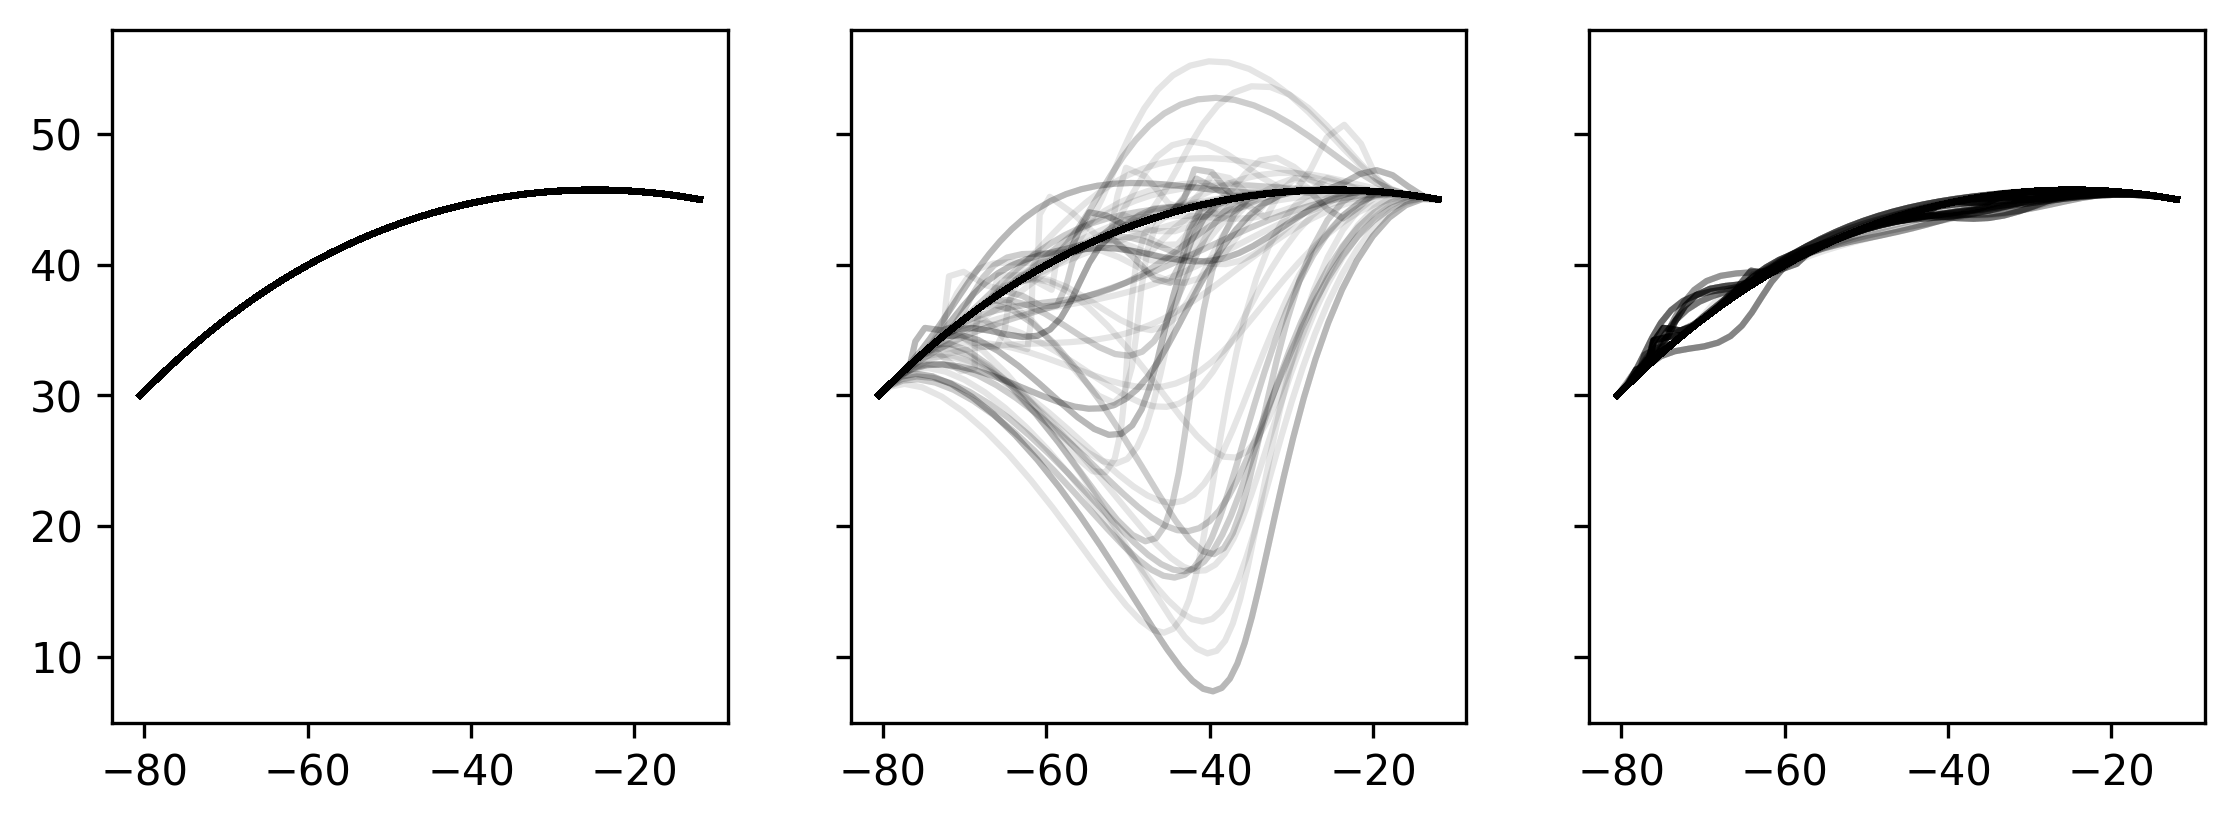

In [25]:
fig, ax = plt.subplots(
    1, len(generations), figsize=(3 * len(generations), 3),
    sharex=True,
    sharey=True,
)
fig.set_dpi(300)

for _g, _ax in zip(generations, ax):
    for lr in _g:
        _ax.plot(lr.route.data_frame.lon, lr.route.data_frame.lat, 'k-', alpha=0.1)

In [26]:
cost = [rl.logs.cost for rl in population]
lengths = [rl.route.length_meters for rl in population]

(array([ 19.,   0.,   7.,   0.,   0.,   0.,   0.,   6.,  44., 332.]),
 array([1.68394127e+12, 1.70951525e+12, 1.73508923e+12, 1.76066321e+12,
        1.78623719e+12, 1.81181117e+12, 1.83738515e+12, 1.86295913e+12,
        1.88853311e+12, 1.91410709e+12, 1.93968107e+12]),
 <BarContainer object of 10 artists>)

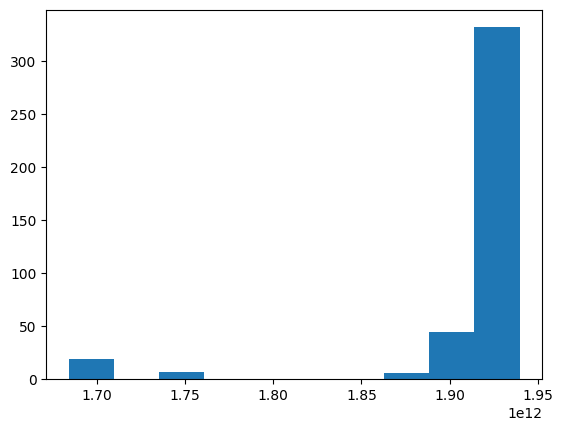

In [27]:
plt.hist(pd.Series(cost).where(pd.Series(cost) < pd.Series(cost).quantile(0.99)).dropna())

In [28]:
route_0.cost_through(_currents, _winds, _waves)

np.float64(1939688124925.8)

In [29]:
np.min(cost) / route_0.cost_through(_currents, _winds, _waves)

np.float64(0.8681505294540938)

In [30]:
imin = np.argmin(cost)
imin

np.int64(136)

In [31]:
population[imin].route.cost_through(_currents, _winds, _waves) / route_0.cost_through(_currents, _winds, _waves)

np.float64(0.8681505294540938)

In [32]:
r_min = population[imin]

In [33]:
len(r_min.route)

41

In [34]:
r_min_grad = gradient_descent(
    route=r_min.route,
    num_iterations=3,
    current_data_set=_currents,
    wind_data_set=_winds,
    wave_data_set=_waves,
)

In [35]:
print(r_min.route.cost_through(_currents, _winds, _waves))
print(r_min_grad[0].cost_through(_currents, _winds, _waves))

1683941272630.1516
1652422886930.3489


In [36]:
r_min_grad[0].cost_through(_currents, _winds, _waves) / route_0.cost_through(_currents, _winds, _waves)

np.float64(0.8519013266596969)

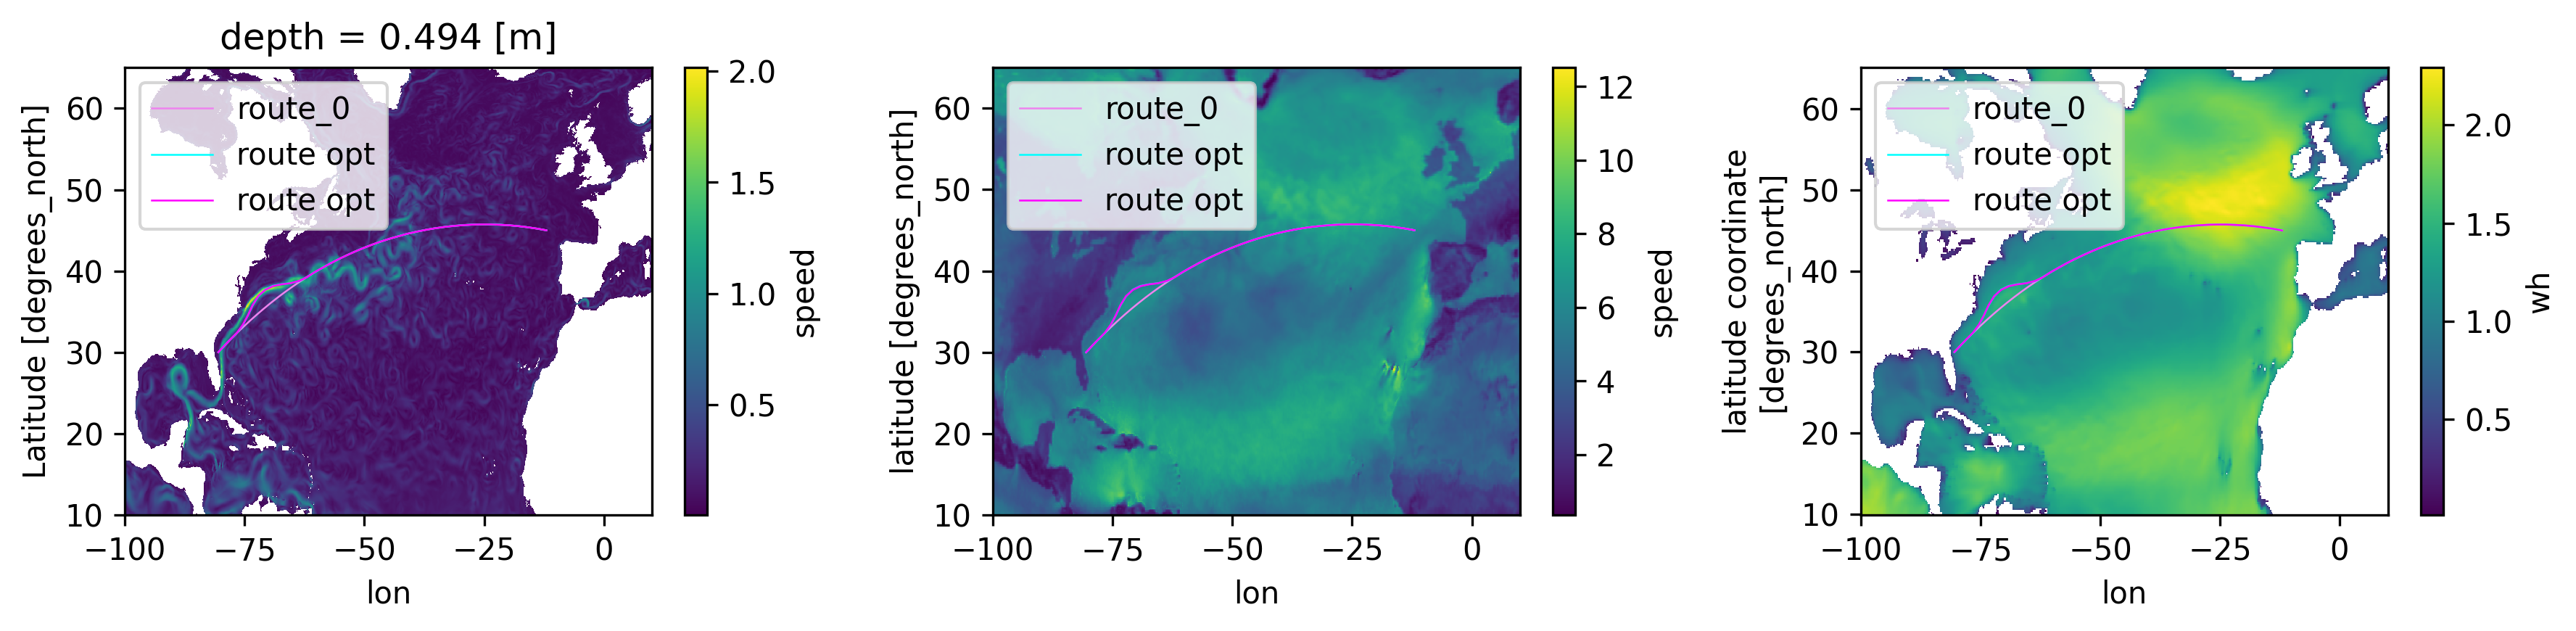

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(300)

_currents.speed.mean("time").plot(ax=ax[0])
_winds.speed.mean("time").plot(ax=ax[1])
_waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", linewidth=.6, ax=_ax, color="violet", label="route_0"
    )
for _ax in ax.flatten():
    population[imin].route.data_frame.plot.line(
        x="lon", y="lat", linewidth=.6, ax=_ax, color="cyan", label="route opt"
    )

for _ax in ax.flatten():
    r_min_grad[0].data_frame.plot.line(
        x="lon", y="lat", linewidth=.6, ax=_ax, color="magenta", label="route opt"
    )

fig.tight_layout();

In [38]:
population_c = sorted(population, key=lambda p: p.logs.cost)

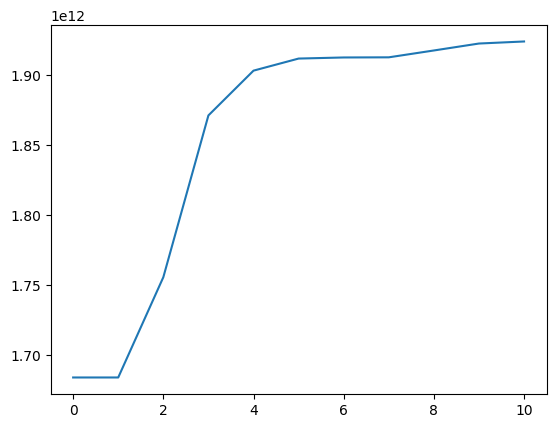

In [51]:
plt.plot(np.quantile(
    [pc.logs.cost for pc in population_c[:100]],
    np.linspace(0, 1, 11),
))

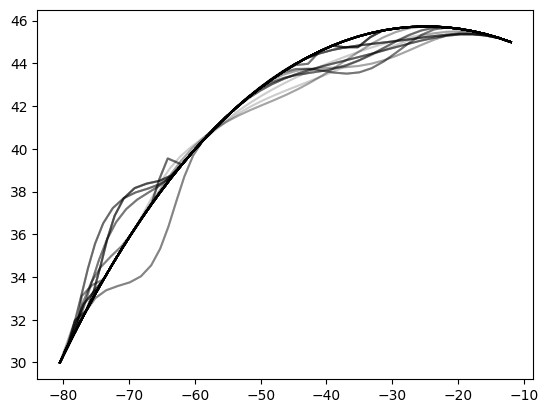

In [41]:
for lr in population_c[:125]:
    plt.plot(lr.route.data_frame.lon, lr.route.data_frame.lat, 'k-', alpha=0.1)

In [40]:
for n in range(100):
    n0 = np.random.randint(25)
    n1 = np.random.randint(25)
    rc = crossover_routes_minimal_cost(
        population_c[n0].route, population_c[n1].route,
        current_data_set=_currents,
        wind_data_set=_winds,
        wave_data_set=_waves,
    )
    print(n0, n1, rc.cost_through(
        current_data_set=_currents,
        wind_data_set=_winds,
        wave_data_set=_waves,
    ))
    
    plt.plot(rc.data_frame.lon, rc.data_frame.lat, 'k-', alpha=0.1)

19 4 1636056995693.5564
21 3 1636056995693.5564
16 6 1676772536531.356
1 22 1636056995693.5564


2025-04-05 12:52:34,971 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw122/micromamba/envs/ship_routing/lib/python3.13/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw122/micromamba/envs/ship_routing/lib/python3.13/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
    )
    ^
  File "/gxfs_home/geomar/smomw122/micromamba/envs/ship_routing/lib/python3.13/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
   

Error in callback <function flush_figures at 0x14606c678720> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

